# Data mining competition #4

## Competition rules

- Goal: prediction of the Prognosis column
- Evaluation metric: balanced accuracy

- Subcompetition 1: use SVM for the prediction (you can use other models for data imputation)
- Subcompetition 2: freeform

**DATA DESCRIPTION**
Predict the severity of COVID-19 in patients of Italian hospitals. The data is collected from 6 hospitals. Chest X-ray images are provided for each patient, which are collected in imgs.npy. Usage of the images are not required for either competition, but it is allowed.

## Variables

- `Age`				Patient’s age (years)
- `Sex`				Patient’s sex (0 – male, 1 – female)
- `Body Temperature (°C)`: Patient temperature at admission (in °C)
- `Cough`: Cough
- `Dyspnea`: Patient had intense tightening in the chest, air hunger, difficulty breathing, breathlessness or feeling of suffocation
- `WBC`: White blood cells count (10^9/L)
- `CRP`: C-reactive protein concentration (mg/dL)
- `Fibrinogen`: Fibrinogen concentration in blood (mg/dL)
- `LDH`: Lactate dehydrogenase concentration in blood (U/L)
- `D-dimer`: D-dimer amount in blood
- `O2`: Oxygen percentage in blood
- `PaO2`: Partial pressure of of oxygen in arterial blood (mmHg)
- `SaO2`: Arterial oxygen saturation (%)
- `pH`: Blood pH
- `Cardiovascular Disease`: Patient had cardiovascular disease
- `Respiratory Failure`: Patient had respiratory failure
- `Image`: Index of corresponding image in imgs.npy (starting from 0)
- `Death`: Whether the patient died (not provided in test column)
- `Prognosis`: Severity of COVID

# Setup

## Libraries

In [189]:
!pip install missingno

In [190]:
import pandas as pd
import numpy as np
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

import plotly.express as px

In [191]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks


## Importing data

In [225]:
data = pd.concat([pd.read_csv(f'COVID/{source}.csv').assign(source=source) for source in ['train', 'test']])

In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1589 entries, 0 to 299
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Row_number             1589 non-null   float64
 1   Hospital               1589 non-null   object 
 2   Age                    1588 non-null   float64
 3   Sex                    1589 non-null   int64  
 4   PositivityAtAdmission  1550 non-null   float64
 5   Temp_C                 1415 non-null   float64
 6   DaysFever              1179 non-null   float64
 7   Cough                  1582 non-null   float64
 8   DifficultyInBreathing  1583 non-null   float64
 9   WBC                    1563 non-null   float64
 10  RBC                    1537 non-null   float64
 11  CRP                    1529 non-null   float64
 12  Fibrinogen             279 non-null    float64
 13  Glucose                1382 non-null   float64
 14  PCT                    913 non-null    float64
 15  LDH  

In [227]:
pd.DataFrame({'count': data.source.value_counts(),
              '%': data.source.value_counts(normalize=True)*100})

,count,%
train,1289,81.120201
test,300,18.879799


# Data preparation

## Missing data

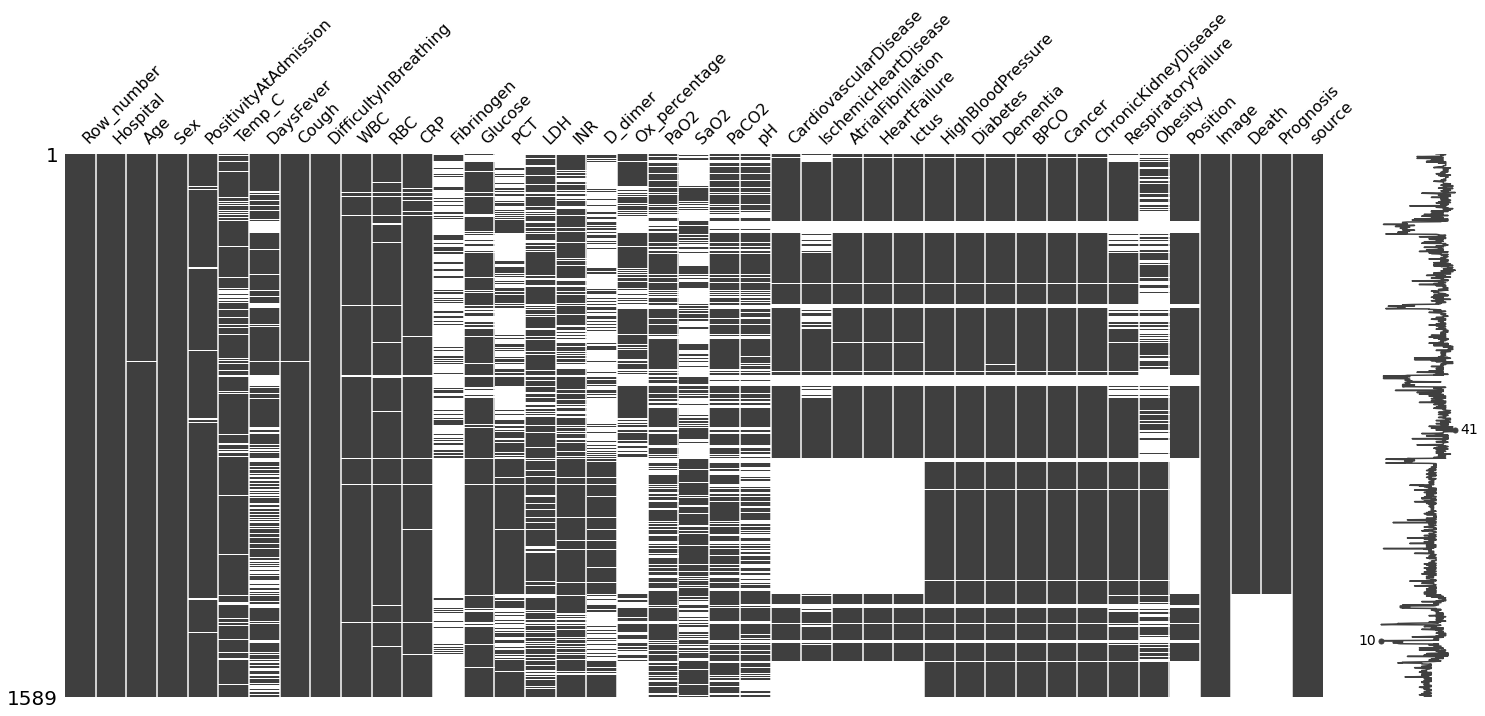

In [228]:
msno.matrix(data)

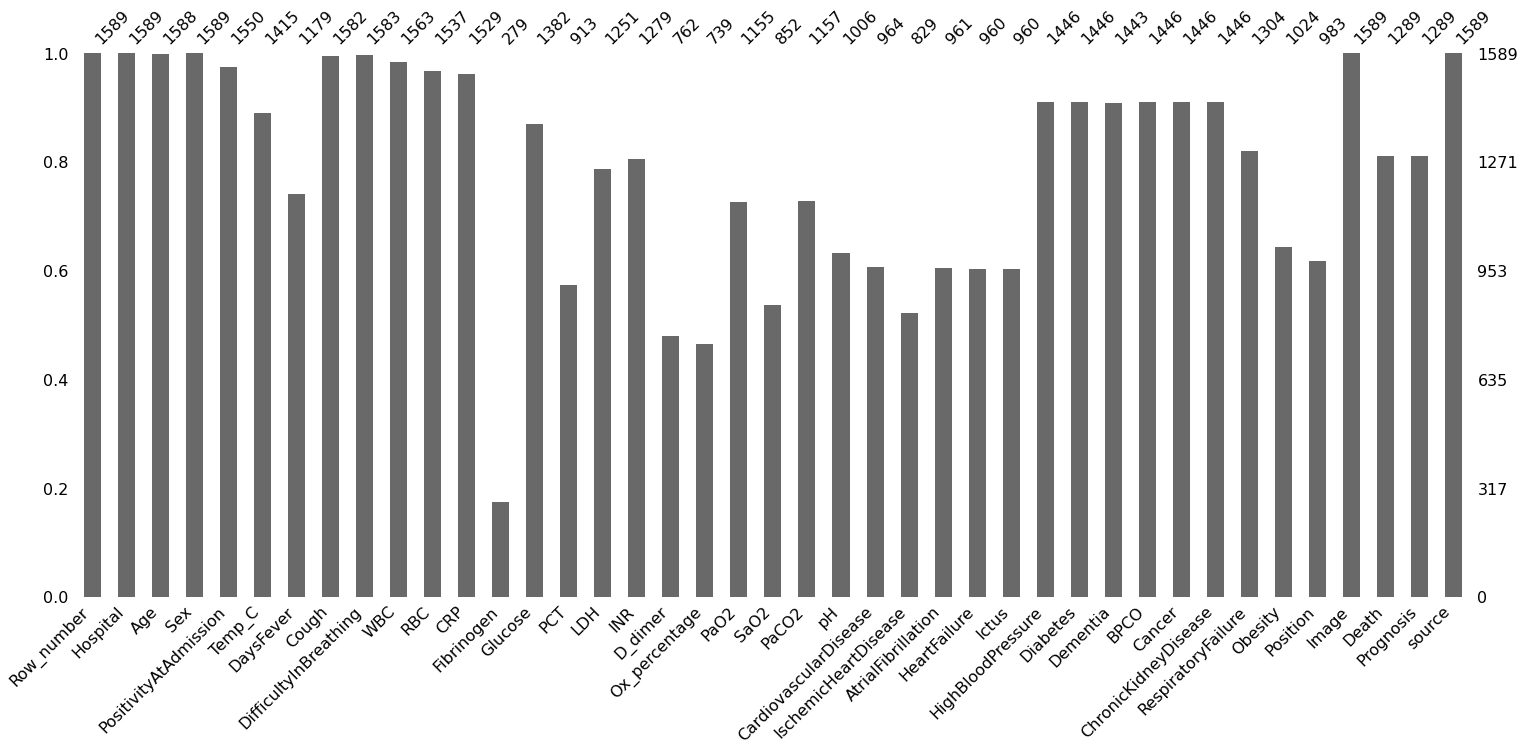

In [229]:
msno.bar(data)

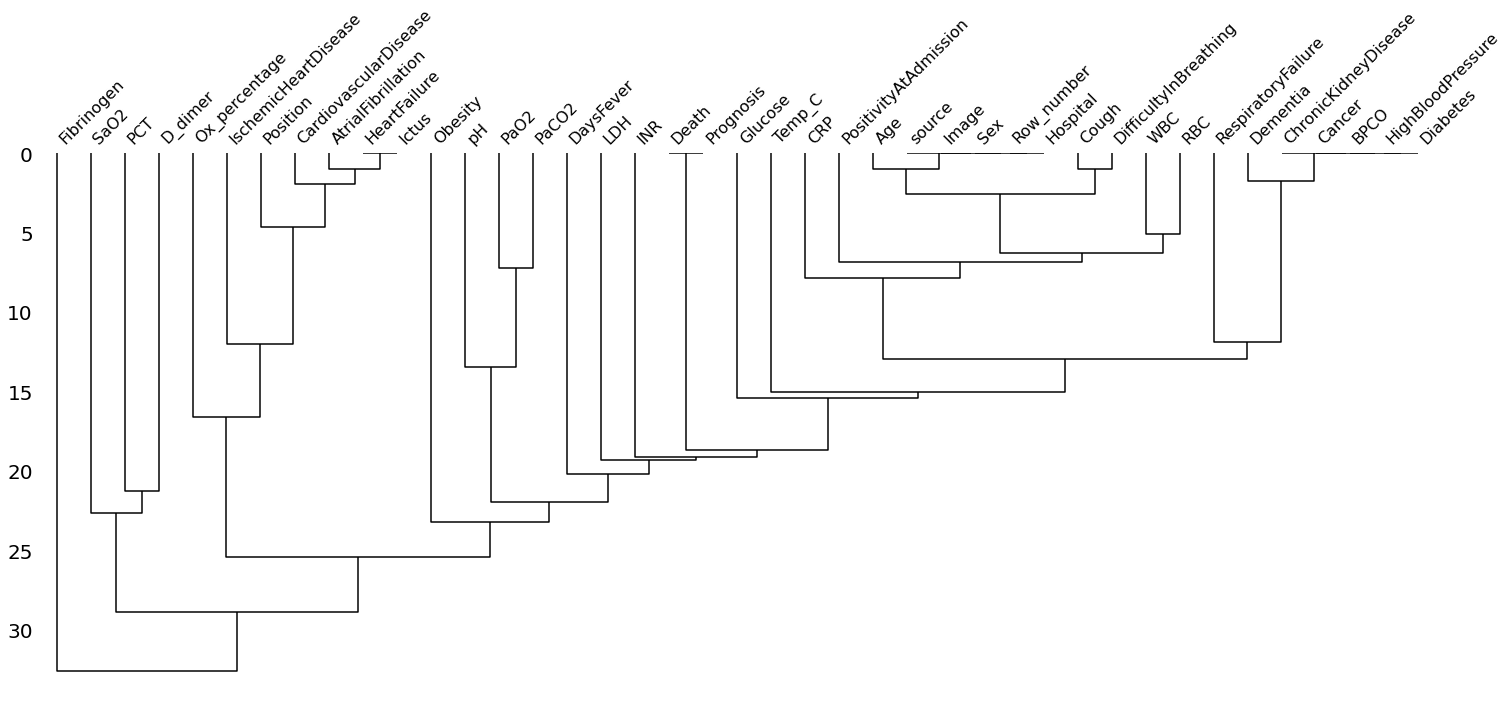

In [230]:
msno.dendrogram(data)

In [231]:
pd.DataFrame({'count': data.isna().sum(),
              '%': (data.isna().sum() / len(data)) * 100}).sort_values(by='%', ascending=False).head(20)

,count,%
Fibrinogen,1310,82.441787
Ox_percentage,850,53.492763
D_dimer,827,52.045312
IschemicHeartDisease,760,47.828823
SaO2,737,46.381372
PCT,676,42.542480
Ictus,629,39.584644
HeartFailure,629,39.584644
AtrialFibrillation,628,39.521712
CardiovascularDisease,625,39.332914


In [232]:
cutoff = 0.19
cols_to_drop = ['Row_number'] + data.isna().sum()[data.isna().sum() / len(data) > cutoff].index.to_list()
print(f'Following columns will be dropped: {cols_to_drop}')
data.drop(columns=cols_to_drop, inplace=True)

Following columns will be dropped: ['Row_number', 'DaysFever', 'Fibrinogen', 'PCT', 'LDH', 'INR', 'D_dimer', 'Ox_percentage', 'PaO2', 'SaO2', 'PaCO2', 'pH', 'CardiovascularDisease', 'IschemicHeartDisease', 'AtrialFibrillation', 'HeartFailure', 'Ictus', 'Obesity', 'Position']


In [233]:
data.isna().sum()

Hospital                   0
Age                        1
Sex                        0
PositivityAtAdmission     39
Temp_C                   174
Cough                      7
DifficultyInBreathing      6
WBC                       26
RBC                       52
CRP                       60
Glucose                  207
HighBloodPressure        143
Diabetes                 143
Dementia                 146
BPCO                     143
Cancer                   143
ChronicKidneyDisease     143
RespiratoryFailure       285
Image                      0
Death                    300
Prognosis                300
source                     0
dtype: int64

In [234]:
data.fillna(-1, inplace=True)
data.loc[data.source == 'test', 'Prognosis'] = np.nan

In [235]:
data.isna().sum()

Hospital                   0
Age                        0
Sex                        0
PositivityAtAdmission      0
Temp_C                     0
Cough                      0
DifficultyInBreathing      0
WBC                        0
RBC                        0
CRP                        0
Glucose                    0
HighBloodPressure          0
Diabetes                   0
Dementia                   0
BPCO                       0
Cancer                     0
ChronicKidneyDisease       0
RespiratoryFailure         0
Image                      0
Death                      0
Prognosis                300
source                     0
dtype: int64

In [236]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1589 entries, 0 to 299
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Hospital               1589 non-null   object 
 1   Age                    1589 non-null   float64
 2   Sex                    1589 non-null   int64  
 3   PositivityAtAdmission  1589 non-null   float64
 4   Temp_C                 1589 non-null   float64
 5   Cough                  1589 non-null   float64
 6   DifficultyInBreathing  1589 non-null   float64
 7   WBC                    1589 non-null   float64
 8   RBC                    1589 non-null   float64
 9   CRP                    1589 non-null   float64
 10  Glucose                1589 non-null   float64
 11  HighBloodPressure      1589 non-null   float64
 12  Diabetes               1589 non-null   float64
 13  Dementia               1589 non-null   float64
 14  BPCO                   1589 non-null   float64
 15  Cance

In [237]:
data.describe()

,Age,Sex,PositivityAtAdmission,Temp_C,Cough,DifficultyInBreathing,WBC,RBC,CRP,Glucose,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Image,Death
count,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000
mean,65.601497,0.371303,0.922593,33.132977,0.441158,0.515419,6.834688,4.395712,24.688615,109.319698,0.342983,0.049087,-0.049717,-0.029578,-0.027061,-0.036501,-0.164884,794.000000,-0.059157
std,15.303310,0.483305,0.347244,12.009506,0.505479,0.507421,3.734667,1.201548,53.153757,67.993543,0.636858,0.476244,0.362847,0.386818,0.390243,0.377152,0.408351,458.849104,0.561372
min,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000
25%,55.000000,0.000000,1.000000,36.100000,0.000000,0.000000,4.530000,4.150000,2.600000,90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,397.000000,0.000000
50%,67.000000,0.000000,1.000000,37.000000,0.000000,1.000000,6.200000,4.590000,8.600000,107.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,794.000000,0.000000
75%,78.000000,1.000000,1.000000,38.000000,1.000000,1.000000,8.320000,4.990000,18.610000,129.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1191.000000,0.000000
max,100.000000,1.000000,1.000000,41.500000,1.000000,1.000000,52.310000,8.340000,570.500000,874.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1588.000000,1.000000


## Encoding

In [238]:
data.columns

Index(['Hospital', 'Age', 'Sex', 'PositivityAtAdmission', 'Temp_C', 'Cough',
       'DifficultyInBreathing', 'WBC', 'RBC', 'CRP', 'Glucose',
       'HighBloodPressure', 'Diabetes', 'Dementia', 'BPCO', 'Cancer',
       'ChronicKidneyDisease', 'RespiratoryFailure', 'Image', 'Death',
       'Prognosis', 'source'],
      dtype='object')

In [239]:
cols_int = ['Age', 'Sex', 'PositivityAtAdmission', 'Cough', 'DifficultyInBreathing', 'HighBloodPressure', 'Diabetes', 'Dementia', 'BPCO', 'Cancer', 'ChronicKidneyDisease', 'RespiratoryFailure', 'Death']
for col in cols_int:
  data[col] = data[col].astype(int)

In [240]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1589 entries, 0 to 299
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Hospital               1589 non-null   object 
 1   Age                    1589 non-null   int64  
 2   Sex                    1589 non-null   int64  
 3   PositivityAtAdmission  1589 non-null   int64  
 4   Temp_C                 1589 non-null   float64
 5   Cough                  1589 non-null   int64  
 6   DifficultyInBreathing  1589 non-null   int64  
 7   WBC                    1589 non-null   float64
 8   RBC                    1589 non-null   float64
 9   CRP                    1589 non-null   float64
 10  Glucose                1589 non-null   float64
 11  HighBloodPressure      1589 non-null   int64  
 12  Diabetes               1589 non-null   int64  
 13  Dementia               1589 non-null   int64  
 14  BPCO                   1589 non-null   int64  
 15  Cance

## Target

In [241]:
data.Prognosis.value_counts()

MILD      690
SEVERE    599
Name: Prognosis, dtype: int64

In [242]:
data.Prognosis = data.Prognosis.str.lower().map({'mild': 0, 'severe': 1})

In [243]:
data.Prognosis

0      0.0
1      0.0
2      0.0
3      1.0
4      0.0
      ... 
295    NaN
296    NaN
297    NaN
298    NaN
299    NaN
Name: Prognosis, Length: 1589, dtype: float64

# Data visualisation

In [244]:
df = data.query('source == "train"').drop('source', axis=1).copy()

In [245]:
df.columns

Index(['Hospital', 'Age', 'Sex', 'PositivityAtAdmission', 'Temp_C', 'Cough',
       'DifficultyInBreathing', 'WBC', 'RBC', 'CRP', 'Glucose',
       'HighBloodPressure', 'Diabetes', 'Dementia', 'BPCO', 'Cancer',
       'ChronicKidneyDisease', 'RespiratoryFailure', 'Image', 'Death',
       'Prognosis'],
      dtype='object')

In [246]:
fig = px.histogram(df, x='Age', y='PositivityAtAdmission', color="Prognosis")
fig.show()

In [247]:
fig = px.box(df, x='Prognosis', y='Age', color='Prognosis')
fig.show()

Generally, people with mild symptoms were younger, with severe symptoms were older.

In [248]:
fig = px.box(df, x='Prognosis', y='Temp_C', color='Prognosis')
fig.show()

Patients with higher body temperature at admission (in °C) tend to have more severe symptoms. The minimum of the range is 35°C which may indicate error.

In [249]:
fig = px.box(df, x='Prognosis', y='WBC', color='Prognosis')
fig.show()

In [250]:
fig = px.box(df, x='Prognosis', y='RBC', color='Prognosis')
fig.show()

In [251]:
fig = px.box(df, x='Prognosis', y='CRP', color='Prognosis')
fig.show()

In [252]:
fig = px.box(df, x='Prognosis', y='Glucose', color='Prognosis')
fig.show()

# One hot encoding

In [253]:
data = pd.concat([pd.get_dummies(data.drop('source', axis=1), drop_first=True), data.source], axis=1)

# Train, test

In [254]:
train = data.query('source == "train"').drop(columns='source').reset_index(drop=True)
test = data.query('source == "test"').drop(columns='source').reset_index(drop=True)
X, y = train.drop(columns='Prognosis'), train['Prognosis']

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelling (SVM)

## Baseline model

In [256]:
clf = SVC()
clf.fit(X_train, y_train)
print(balanced_accuracy_score(y_test, clf.predict(X_test)))

0.5528143274853802


## Search

In [275]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 50, 100, 200, 500, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid'],
              'class_weight': ['balanced']}
 
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=0)
grid.fit(X_train, y_train)
print(balanced_accuracy_score(y_test, grid.predict(X_test)))
print(grid.best_params_)
print(grid.best_estimator_)
best_svc = grid.best_estimator_

0.6524122807017544
{'C': 1000, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=1000, class_weight='balanced', gamma=0.0001)


# Modelling (XGB)

## Baseline model

In [260]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
print(balanced_accuracy_score(y_test, clf.predict(X_test)))

0.764985380116959


## Search

In [262]:
param_grid = {
"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30] ,
"max_depth"        : [3, 4, 5, 6, 8, 10, 12, 15],
"min_child_weight" : [1, 3, 5, 7],
"gamma"            : [0.0, 0.1, 0.2, 0.3, 0.4],
"colsample_bytree" : [0.3, 0.4, 0.5, 0.7] }

grid = GridSearchCV(XGBClassifier(), param_grid, refit=True, verbose=0)
grid.fit(X_train, y_train)
print(balanced_accuracy_score(y_test, grid.predict(X_test)))
print(grid.best_params_)
print(grid.best_estimator_)
best_xgb = grid.best_estimator_

0.7545687134502924
{'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.15, 'max_depth': 3, 'min_child_weight': 3}
XGBClassifier(colsample_bytree=0.7, gamma=0.0, learning_rate=0.15,
              min_child_weight=3)


# Submissions

In [271]:
def create_submission(model):
    return pd.DataFrame({'Id': test.index.values,
                         'Prognosis': model.predict(test.drop('Prognosis', axis=1))})\
             .set_index('Id')

In [272]:
create_submission(grid)

,Prognosis
Id,
0,1.0
1,0.0
2,0.0
3,0.0
4,1.0
...,...
295,0.0
296,0.0
297,0.0


In [277]:
my_name = 'Balázs_Nagy'
for submission_number, model in {'1': best_svc, '2': best_xgb}.items():
    print(model)
    df_submission = create_submission(model=model)
    filename = f'dm_competition4_{my_name}_submission{submission_number}.txt'
    df_submission.to_csv(filename, index=False, header=None)
    print(df_submission.head(5), '\n' + '*'*75 + '\n')

SVC(C=1000, class_weight='balanced', gamma=0.0001)
    Prognosis
Id           
0         1.0
1         0.0
2         1.0
3         1.0
4         0.0 
***************************************************************************

XGBClassifier(colsample_bytree=0.7, gamma=0.0, learning_rate=0.15,
              min_child_weight=3)
    Prognosis
Id           
0         1.0
1         0.0
2         0.0
3         0.0
4         1.0 
***************************************************************************

